**Daehyun Cho Neuroimaging(BRI609) HW1**

*Note that numbered headers refer to the workflow of what I did, and alphabetic headers refer to the assignment*

# [0] Data Preparation

## 0.1 Import

In [1]:
import math, random
from glob import glob
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import clear_output

import nibabel as nib
from nibabel.brikhead import *

from nilearn import plotting

## 0.2 Load Data
For this stage, I aimed to make -
+ for each task(ad, lh, rh, vs)
+ for each subjects,
+ not all voxels, but their ROIs respectively **averaged**
 
which ends up with data shape of `(# subs, x, y, z, bold by time)` for each task respectively

### 0.2.1 Load ROI Mask

In [3]:
masks = { # {task: [(x, y, z) ...]}
    k: [(x, y, z) for x, y, z in zip(*np.where(nib.load(v).get_fdata() != 0)[:-1])]
    for k, v in zip(['ad', 'lh', 'rh', 'vs'], glob('./stats/ttest/*.gz'))
}

### 0.2.2 Load BOLD Signal

In [33]:
tasks = ['ad', 'lh', 'rh', 'vs']
sub_ids = range(2, 14)
get_img = lambda x: nib.load(x).get_fdata()

BOLD = {task: dict() for task in tasks}
BOLD_voxel = {task: dict() for task in tasks}
for sub_id in sub_ids:
    sub_id = f'{str(sub_id).zfill(2)}'
    dir_sub_id = glob(f'./data/s{sub_id}/ad_lh_rh_vs/s{sub_id}.results/*.brik')
    
    for i, task in enumerate(tasks):
        BOLD[task][sub_id] = get_img(dir_sub_id[i])
        
        BOLD_voxel[task][sub_id] = np.array([BOLD[task][sub_id][p] for p in masks[task]])
        BOLD[task][sub_id] = sum(BOLD[task][sub_id][p] for p in masks[task]) / len(masks[task])

Now each task dictionary contains for each subjects averaged BOLD signal of their ROIs. For example auditory task(`ad`), subject 02's bold signals are as followed

In [34]:
BOLD['ad']['02']

array([712.71224976, 711.59639486, 715.65416463, 714.17563883,
       712.99129028, 713.13711141, 713.43453979, 714.50793864,
       715.3414388 , 714.24032186, 714.13745728, 712.94888306,
       715.91298625, 720.51322835, 716.42850545, 712.49010213,
       711.36983846, 711.86590169, 712.38032633, 715.66875407,
       715.06452433, 714.90030721, 713.24330037, 714.30494181,
       714.73956502, 711.46162923, 710.234198  , 710.14152425,
       712.74313965, 712.50687866])

In [37]:
BOLD_voxel['ad']['02']

array([[692.21069336, 694.02716064, 694.38128662, 698.09533691,
        692.1463623 , 694.31604004, 693.61791992, 694.38043213,
        694.01550293, 693.05603027, 692.065979  , 695.65527344,
        696.74694824, 698.39709473, 695.89080811, 694.64794922,
        692.03961182, 693.94067383, 690.53723145, 693.9050293 ,
        694.94805908, 693.60083008, 693.78027344, 697.56286621,
        693.7855835 , 693.73840332, 695.66680908, 691.43255615,
        692.22369385, 694.98132324],
       [695.24316406, 698.14862061, 698.44897461, 703.35864258,
        695.703125  , 698.60137939, 697.24243164, 699.49493408,
        698.89154053, 696.62994385, 696.39709473, 699.95617676,
        701.01489258, 704.58294678, 700.17333984, 698.55493164,
        696.91381836, 697.77972412, 695.16741943, 698.64685059,
        698.54943848, 698.61682129, 697.40460205, 700.38641357,
        698.74536133, 698.49359131, 698.63397217, 696.94091797,
        697.90081787, 698.69476318],
       [713.19195557, 714.3001

### 0.a Each of the task was performed at 20s during 4s (i.e., 10, 11 TRs). Please use boxcar model for neural activity

So if 10, 11 TR was activated, we should make neuronal activity that looks like the one below

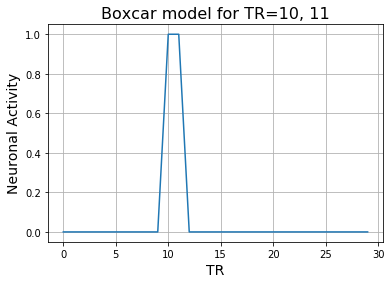

In [8]:
# BOXCAR
boxcar = np.array(
    [0] * 10 +
    [1] * 2  +
    [0] * 18
)

# PLOT
plt.plot(boxcar)
plt.title('Boxcar model for TR=10, 11', fontsize=16)
plt.xlabel('TR', fontsize=14)
plt.ylabel('Neuronal Activity', fontsize=14)
plt.grid()
plt.show()

### 0.b Consider the 0-20s, (i.e. 0 - 9 TRs) and 40-60s(i.e. 20 - 29 TRs) as baseline period.

Since baseilne period should be made by task and subject all respectively(making 11 * 4, which is too many), I'll make a function for this, so I can get the baseline whenever I want

In [9]:
baseline = lambda task, sub_id: (sum(BOLD[task][sub_id][0:10]) + sum(BOLD[task][sub_id][20:])) / 20

In [38]:
baseline_voxel = lambda task, sub_id: [(sum(voxel[0:10]) + sum(voxel[20:])) / 20 for voxel in BOLD_voxel[task][sub_id]]

For example, if I want to get the baseline of subject 02's auditory task baseline BOLD signal, just type - 

In [39]:
baseline('ad', '02')

713.3565548706055

In [41]:
baseline_voxel('ad', '02')

[694.0983581542969,
 698.3064727783203,
 715.2692810058594,
 697.1376525878907,
 705.9301788330079,
 692.4888519287109,
 701.4590118408203,
 717.9994293212891,
 719.9401641845703,
 722.6351470947266,
 740.7563385009765,
 701.0196258544922,
 707.4536987304688,
 716.9288726806641,
 713.3628814697265,
 719.8550903320313,
 713.2067779541015,
 724.1539245605469,
 725.1333465576172,
 739.9255584716797,
 731.3019927978515,
 704.2109832763672,
 716.8645904541015,
 723.0722747802735,
 721.2992492675781,
 724.2509674072265,
 711.794775390625,
 688.5262268066406,
 712.7273376464843,
 699.5875854492188]

### 0.c Calculate the percentage(%) BOLD (pBOLD) signal based on (b)

In [11]:
def pBOLD(task, sub_id):
    
    base = baseline(task, sub_id)
    return (BOLD[task][sub_id] - base) / base * 100

In [42]:
def pBOLD_voxel(task, sub_id):
    
    base = baseline_voxel(task, sub_id)
    return (BOLD_voxel[task][sub_id] - base) / base * 100

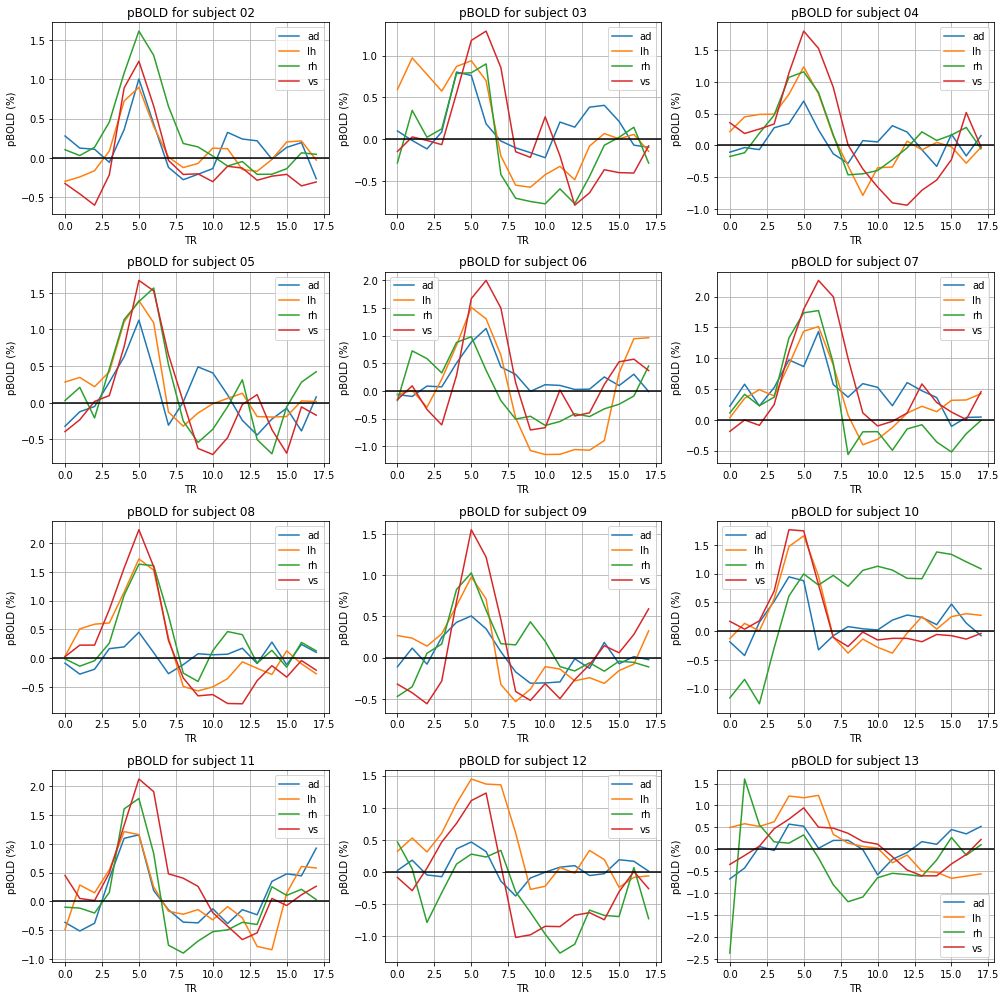

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(14, 14))
for sub_id in sub_ids:
    
    row, col = (sub_id - 2) // 3, (sub_id - 2) % 3
    sub_id = f'{str(sub_id).zfill(2)}'
    for task in tasks:
        axes[row, col].plot(pBOLD(task, sub_id)[8:26], label=task)
        
    axes[row, col].grid()
    axes[row, col].set_title(f'pBOLD for subject {sub_id}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_ylabel('pBOLD (%)')
    axes[row, col].axhline(0, color='black')
    axes[row, col].legend()
    
fig.tight_layout()

I drew an `y=0` in order to clearly see the baseline.

### 0.d Conduct the estimation of HRFs using the pBOLD signals calculated in (c) by applying each of the following methods [1] - [4]

Now we conduct the estimation.

# [1] Deconvolution Approach

### 1.a Set the reasonable number of Fast Fourier Transform (FFT) points

### 1.b Perform the FFT and inverse FFT to estimate the HRF in the time domain for each of the voxels in the ROI

### 1.c Check the estimated HRFs across the voxels and average the estimated HRFs

### 1.d Evaluate your results by comparing the average estimated HRF and average pBOLD signal

# [2] Using a flexible mathematical model of HRF - One Gamma Function

### 2.a Set the reasonable range of values as a grid for each of the parameters (i.e. $T_0$, $n$, and $\lambda$)

I'll denote the variables as follows
+ $T_0$ as `T0`
+ $n$ as `n`
+ $\lambda$ as `l`

In [16]:
params_one = {
    'T0': [0],
    'n' : [i * .01 for i in range(200, 400)],
    'l' : [i * .001 for i in range(1000, 2000)]
}

### 2.b Calculate Pearsons's correlation coefficients(CC) between the pBOLD signal and estimated pBOLD from the modeled HRF across all combinatorial sets of model parameters for *each voxel*

Phew, there are much things to be done here.
1. Make `one_gamma` function - *remember to use TR=9~25 only*
2. Get combintaions of parameter grids
3. Calculate Pearson's Correlation

### 2.1 Make `one_gamma` function

In [17]:
fact = math.factorial
def one_gamma(params: list, t=None):
    
    t0, n, lamb = params
    if t is None: t = np.arange(0, 18)
    return (t - t0)**n / (lamb**n * math.gamma(n)) * np.exp(-t/lamb)

See if it looks fine

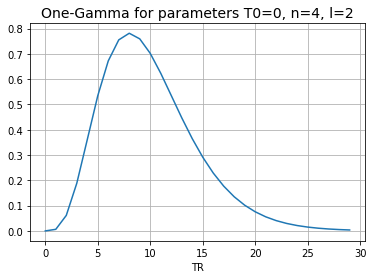

In [18]:
plt.plot(one_gamma([0, 4, 2], t=np.arange(0, 30)))
plt.title('One-Gamma for parameters T0=0, n=4, l=2', fontsize=14)
plt.xlabel('TR')
plt.grid()

### 2.2 Get combinations of parameter grid

Since there are too many cases of parameters to consider, I can't iterate them all by myself. Make a function for this.

In [19]:
cases = lambda cases: list(product(*cases.values()))

So that it conatins all the set of parameters seen as below

In [20]:
cases(params_one)

[(0, 2.0, 1.0),
 (0, 2.0, 1.0010000000000001),
 (0, 2.0, 1.002),
 (0, 2.0, 1.0030000000000001),
 (0, 2.0, 1.004),
 (0, 2.0, 1.0050000000000001),
 (0, 2.0, 1.006),
 (0, 2.0, 1.0070000000000001),
 (0, 2.0, 1.008),
 (0, 2.0, 1.0090000000000001),
 (0, 2.0, 1.01),
 (0, 2.0, 1.0110000000000001),
 (0, 2.0, 1.012),
 (0, 2.0, 1.0130000000000001),
 (0, 2.0, 1.014),
 (0, 2.0, 1.0150000000000001),
 (0, 2.0, 1.016),
 (0, 2.0, 1.0170000000000001),
 (0, 2.0, 1.018),
 (0, 2.0, 1.0190000000000001),
 (0, 2.0, 1.02),
 (0, 2.0, 1.0210000000000001),
 (0, 2.0, 1.022),
 (0, 2.0, 1.0230000000000001),
 (0, 2.0, 1.024),
 (0, 2.0, 1.025),
 (0, 2.0, 1.026),
 (0, 2.0, 1.027),
 (0, 2.0, 1.028),
 (0, 2.0, 1.029),
 (0, 2.0, 1.03),
 (0, 2.0, 1.031),
 (0, 2.0, 1.032),
 (0, 2.0, 1.033),
 (0, 2.0, 1.034),
 (0, 2.0, 1.035),
 (0, 2.0, 1.036),
 (0, 2.0, 1.037),
 (0, 2.0, 1.038),
 (0, 2.0, 1.039),
 (0, 2.0, 1.04),
 (0, 2.0, 1.041),
 (0, 2.0, 1.042),
 (0, 2.0, 1.043),
 (0, 2.0, 1.044),
 (0, 2.0, 1.045),
 (0, 2.0, 1.046),
 (0,

with each case, I can make HRF. Let's plot some sampling from cases.

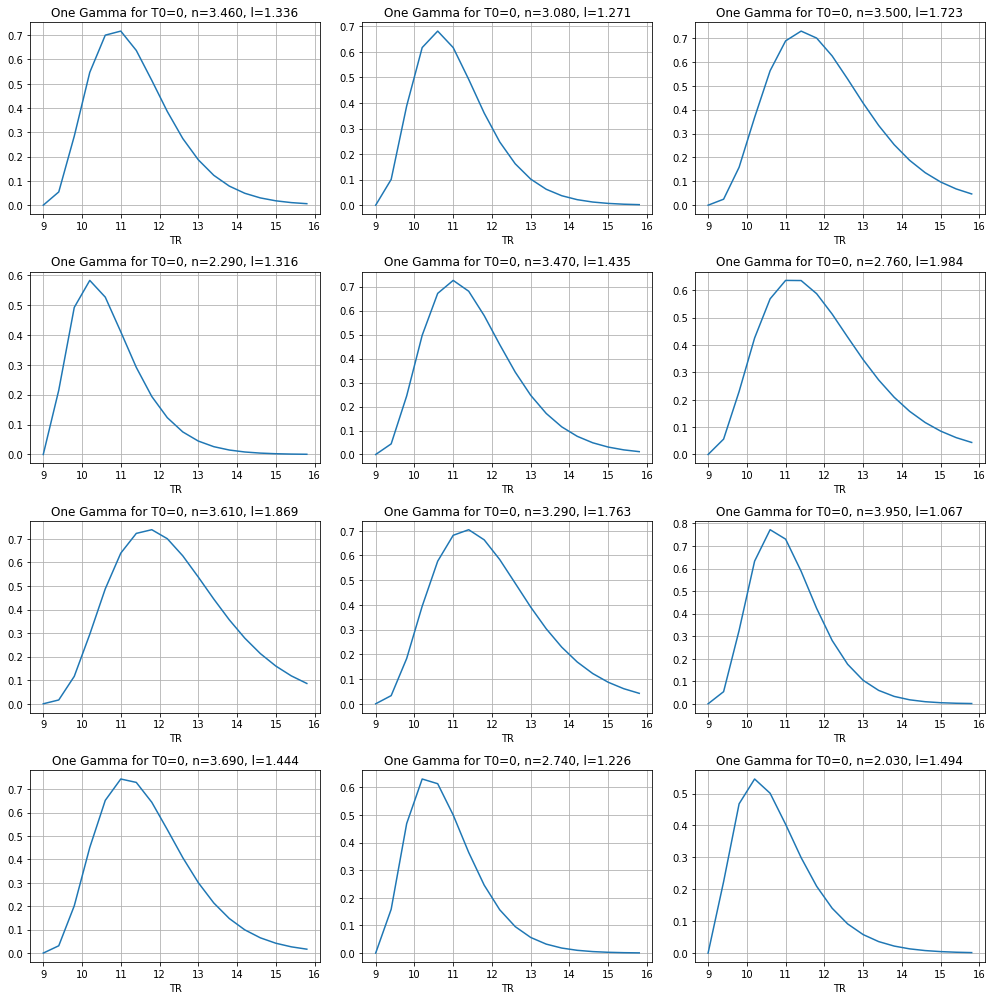

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(14, 14))
for i in range(12):
    
    row, col = i // 3, i % 3
    sample = random.choice(cases(params_one))
    
    axes[row, col].plot(one_gamma(sample))
    T0, n, l = sample
    axes[row, col].set_title(f'One Gamma for T0={T0}, n={n:.3f}, l={l:.3f}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18)])
    axes[row, col].grid()
    
fig.tight_layout()

### 2.3 Calculate Correlations

With p

In [25]:
def corr_voxel(bold_voxel, hrf):
    
    return [np.corrcoef(voxel[8:26], hrf)[0][1] for voxel in bold_voxel]

In [ ]:
corr_voxel(pBOLD())

In [22]:
corr = lambda bold, hrf: np.corrcoef(bold[8:26], hrf)[0][1]

In [23]:
corr(pBOLD('ad', '02'), one_gamma(sample))

0.2936634862073938